<a href="https://colab.research.google.com/github/libraun/seq2seq_gen/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
from collections import Counter
import pandas as pd

import nltk

import random
import math

random.seed(12)

import torch
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence

import spacy

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
MASK_RATIO = 0.0
MASK_TOKENS = False
def mask(sequence: torch.tensor):
  trg_masked_tokens = math.floor(len(sequence) * MASK_RATIO)
  indices = [_ for _ in range(len(sequence))]
  for idx in random.sample(indices, k=trg_masked_tokens):
    sequence[idx] = MASK_IDX

In [ ]:
#INPUT_FILEPATH = "/content/drive/MyDrive/advertisement_data.csv"
OUTPUT_FILEPATH = "result_strings.txt" # Path to place predicted strings

MODEL_FILE = "Seq2Seq_lit.pt"
LOAD_FROM_FILE = False

#df = pd.read_csv(INPUT_FILEPATH, encoding='utf8')
try:
  data = nltk.corpus.gutenberg.sents("austen-emma.txt")
except:
  nltk.download('punkt')
  nltk.download('gutenberg')

data = nltk.corpus.gutenberg.sents("austen-emma.txt")
text_inputs = [" ".join([w for w in data[i]]) for i in range(0,len(data),2)]
text_outputs = [" ".join([w for w in data[i+1]]) for i in range(0,len(data),2)]
#text_inputs = df["product"] + ' ' + df["description"]
#text_outputs = df["ad"]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 40

In [ ]:
PUNCTUATION_PATTERN = re.compile('[\"\?\!\'\;\.\]\&-\[><\}&\-+={]')
REPEAT_WHITESPACE_PATTERN = re.compile(' {2,}')

# Randomize the words in a sentence for crossentropy loss
def update_encoder_dict(encoder_dict, words: list, randomize: bool):
  if randomize: random.shuffle(words)
  encoder_dict.update(words)

# Preprocess data, storing the preprocessed stringsd
# back into data.
def preprocess(data, out, tokenizer, random_encodings: bool):
  for i, line in enumerate(data):
    line = re.sub(PUNCTUATION_PATTERN, ' ', line.lower())
    line = " ".join([w for w in tokenizer(line) \
        if '\\' not in str(w.encode('utf8')) and w.isalpha()])
    line = re.sub(REPEAT_WHITESPACE_PATTERN, '', line)
    line = re.sub('\t','',line)
    data[i] = line

token_to_idx = Counter()

tokenizer = get_tokenizer("spacy",language="en_core_web_sm")
preprocess(text_inputs, token_to_idx, tokenizer, True)
preprocess(text_outputs, token_to_idx, tokenizer, True)

for i in range(len(text_inputs)):
  in_line = text_inputs[i]
  out_line = text_outputs[i]

  joined_sent = in_line + ' ' + out_line
  joined_sent = re.sub(REPEAT_WHITESPACE_PATTERN, ' ', joined_sent)
  update_encoder_dict(token_to_idx, tokenizer(joined_sent), randomize=True)

In [ ]:
specials = ["<unk>","<pad>","<bos>","<eos>"] # Special words for tokenizer.

if MASK_TOKENS: # Append a "<mask>" token to specials if masking enabled.
  specials.append("<mask>")

en_vocab = vocab(token_to_idx,specials=specials)
en_vocab.set_default_index(en_vocab["<unk>"])

PAD_IDX = en_vocab["<pad>"]
BOS_IDX = en_vocab["<bos>"]
EOS_IDX = en_vocab["<eos>"]
# Enable mask idx if masking enabled.
if MASK_TOKENS:
  MASK_IDX = en_vocab["<mask>"]

In [ ]:
data = []
# Iterate over all data (src & trg), tokenize,
# and make tensors. If masking is enabled, mask before adding to data.
for i in range(len(text_inputs)):
  input_i = tokenizer(text_inputs[i])
  output_i = tokenizer(text_outputs[i])

  input_tensor = torch.tensor([en_vocab[word] for word in input_i],
                              dtype=torch.long)
  output_tensor = torch.tensor([en_vocab[word] for word in output_i],
                               dtype=torch.long)
  # Mask tokens ONLY FOR TRAINING DATA
  #MASK_TOKENS = i < 1000
  #if MASK_TOKENS:
   # mask(input_tensor); mask(output_tensor)
  data.append((input_tensor, output_tensor))
# Split lines into train,validation,& testing datasets respectively.

train_data = data[ : 3100 ]
valid_data = data[ 3100 : 3850 ]
test_data = data[ 3850 : ]

print(len(train_data), len(valid_data), len(test_data))

3100 750 26


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_dim,emb_dim,hid_dim,n_layers,dropout,device):
    super().__init__()
    self.embedding = nn.Embedding(input_dim, emb_dim,
                                  padding_idx=PAD_IDX,
                                  device=device)
    self.dropout = nn.Dropout(p=dropout)
    self.rnn = nn.LSTM(emb_dim, hid_dim,
                       num_layers=n_layers,
                       dropout=dropout)
  def forward(self,src):
    embedded = self.dropout(self.embedding(src))
    outputs, (hidden, cell) = self.rnn(embedded)
    return hidden, cell

class Decoder(nn.Module):
  def __init__(self,d_model,emb_dim,hid_dim,n_layers,dropout,device):
    super().__init__()
    self.output_dim = d_model
    self.embedding = nn.Embedding(d_model, emb_dim,
                                  padding_idx=PAD_IDX,
                                  device=device)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.LSTM(emb_dim, hid_dim,
                       num_layers=n_layers,
                       dropout=dropout)
    self.fc_out = nn.Linear(hid_dim, d_model)

  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)
    embedded = self.dropout(self.embedding(input))
    output, (hidden, cell) = self.rnn(embedded)
    prediction = self.fc_out(output.squeeze(0))
    return prediction, hidden, cell
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
  def forward(self, src, trg):
    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    hidden, cell = self.encoder.forward(src)
    input = trg[0]
    for i, input_seq in enumerate(trg):
      output, hidden, cell = self.decoder.forward(input_seq, hidden, cell)
      outputs[i] = output
    return outputs

In [ ]:
VOCAB_SIZE = len(en_vocab.vocab)
EMB_DIM = 512
DROPOUT = 0.5
HID_DIM = 256
N_LAYERS = 2
BATCH_SIZE = 128

encoder = Encoder(VOCAB_SIZE,EMB_DIM,HID_DIM,N_LAYERS,DROPOUT,device)
decoder = Decoder(VOCAB_SIZE,EMB_DIM,HID_DIM,N_LAYERS,DROPOUT,device)
model = Seq2Seq(encoder, decoder, device).to(device)

if LOAD_FROM_FILE:
  model.load_state_dict(torch.load(MODEL_FILE))

def init_weights(m):
  for _, param in m.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)

#model.apply(init_weights)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def collate(data_batch):
  in_batch,out_batch = [],[]
  for (in_item, out_item) in data_batch:
    in_batch.append(torch.cat([
        torch.tensor([BOS_IDX],dtype=torch.long),
        in_item,
        torch.tensor([EOS_IDX],dtype=torch.long)],dim=0))
    out_batch.append(torch.cat([
        torch.tensor([BOS_IDX],dtype=torch.long),
        out_item,
        torch.tensor([EOS_IDX],dtype=torch.long)],dim=0))
  in_batch = pad_sequence(in_batch, padding_value=PAD_IDX)
  out_batch = pad_sequence(out_batch, padding_value=PAD_IDX)
  return in_batch,out_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate)

In [ ]:
def evaluate(iter):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for src, trg in iter:
      src,trg = src.to(device), trg.to(device)
      output = model(src, trg)
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)
      loss = criterion(output, trg)
      epoch_loss += loss.item()
  return epoch_loss / len(iter)

In [ ]:
UPDATE_MSG = "Epoch {n}: Train loss={t_loss:.2f} | Eval loss = {e_loss:.2f}"
def train(log_msg=True):
  train_loss_values = []
  validation_loss_values = []
  for i in range(NUM_EPOCHS):
    epoch_loss = 0
    model.train() # Set training to true
    for src, trg in train_iter:
      src, trg = src.to(device), trg.to(device)
      optimizer.zero_grad()
      output = model(src, trg)
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)
      loss = criterion(output,trg)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
      optimizer.step()
      epoch_loss += loss.item()
    # Add mean loss value as epoch loss.
    epoch_loss = epoch_loss / len(train_iter)
    val_loss = evaluate(valid_iter)

    train_loss_values.append(epoch_loss)
    validation_loss_values.append(val_loss)

    if log_msg: # Output epoch progress if log_msg is enabled.
      print(UPDATE_MSG.format(n = i + 1,
                              t_loss = epoch_loss,
                              e_loss = val_loss))
  return train_loss_values, validation_loss_values

In [ ]:
train_losses, val_losses = train()
torch.save(model.state_dict(),MODEL_FILE)



test_loss = evaluate(test_iter)

Epoch 1: Train loss=9.26 | Eval loss = 8.05
Epoch 2: Train loss=6.36 | Eval loss = 5.00
Epoch 3: Train loss=4.57 | Eval loss = 4.03
Epoch 4: Train loss=3.79 | Eval loss = 3.46
Epoch 5: Train loss=3.29 | Eval loss = 3.11
Epoch 6: Train loss=2.93 | Eval loss = 2.84
Epoch 7: Train loss=2.66 | Eval loss = 2.63
Epoch 8: Train loss=2.42 | Eval loss = 2.47
Epoch 9: Train loss=2.23 | Eval loss = 2.35
Epoch 10: Train loss=2.08 | Eval loss = 2.24
Epoch 11: Train loss=1.94 | Eval loss = 2.17
Epoch 12: Train loss=1.82 | Eval loss = 2.11
Epoch 13: Train loss=1.70 | Eval loss = 2.05
Epoch 14: Train loss=1.62 | Eval loss = 2.00
Epoch 15: Train loss=1.53 | Eval loss = 1.96
Epoch 16: Train loss=1.45 | Eval loss = 1.93
Epoch 17: Train loss=1.38 | Eval loss = 1.91
Epoch 18: Train loss=1.31 | Eval loss = 1.88
Epoch 19: Train loss=1.25 | Eval loss = 1.85
Epoch 20: Train loss=1.18 | Eval loss = 1.84
Epoch 21: Train loss=1.13 | Eval loss = 1.83
Epoch 22: Train loss=1.09 | Eval loss = 1.81
Epoch 23: Train los

In [ ]:
itos = en_vocab.vocab.get_itos() # Index to string (for getting words)
model.eval()
output_sents = [] # List of output sentences predicted by model
print("Total params: ", model.params())
with torch.no_grad():
  for src,trg in test_iter:
    src,trg = src.to(device),trg.to(device)
    output = model(src, trg)
    out_view = output.argmax(1).argmax(1)
    str_out = " ".join([itos[w] for w in out_view if w > 3])
    output_sents.append(str_out)
# Evaluate Testing Data
test_acc = evaluate(test_iter)
# Append each sent to file
for i, sent in enumerate(output_sents):
  print(sent)
  with open(OUTPUT_FILEPATH,"a") as f:
    f.write(sent)

being fond and and by emma to a lived happy existenceand a a emma by fatherand chapter and by remembrance by chapter mistress too little and by woodhousehandsomecleverand chapter a a fatherand emma volume dispositionseemed jane emma woodhousehandsomecleverand jane emma by emma and i chapter i chapter i


[8.050164063771566, 5.000709931055705, 4.025199135144551, 3.462732950846354, 3.107094883918762, 2.8369223276774087, 2.6255303223927817, 2.473153988520304, 2.349665323893229, 2.2351775964101157, 2.1688478191693625, 2.105809132258097, 2.0491684675216675, 1.9955472747484844, 1.9556129972139995, 1.9272026817003887, 1.9055343866348267, 1.8752751151720684, 1.8484165668487549, 1.8376752535502117, 1.8254522681236267, 1.811396022637685, 1.8138175408045452, 1.7991627057393391, 1.7928839524586995, 1.7917455037434895, 1.7890502214431763, 1.7785317103068035, 1.7777408361434937, 1.7763645251592, 1.7752293546994526, 1.7757134040196736, 1.7817357182502747, 1.7809744874636333, 1.7836223045984905, 1.7822164098421733, 1.800281246503194, 1.7944048444430034, 1.8072867790857952, 1.8037774364153545]


Text(0.5, 0, 'Training Intervals')

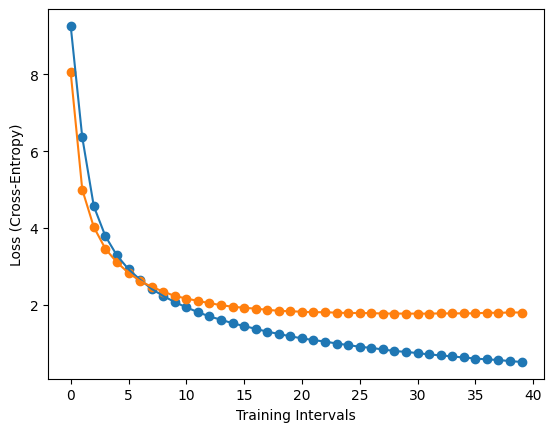

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss for training set
plt.scatter([i for i in range(NUM_EPOCHS)], train_losses)
plt.plot([i for i in range(NUM_EPOCHS)], train_losses)

# Plotting loss for validation set
plt.scatter([i for i in range(NUM_EPOCHS)], val_losses)
plt.plot([i for i in range(NUM_EPOCHS)], val_losses)

plt.ylabel("Loss (Cross-Entropy)")
plt.xlabel("Training Intervals")